In [0]:
# imports.
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [0]:
# read in the data.
df = pd.read_csv('https://raw.githubusercontent.com/spotify-song-suggester-1/spotify-app/master/ds/Data/SpotifyTracks_doubleforloop_genre_year.csv',index_col=[0])
# show the data frame shape.
print(df.shape)
# show the data frame with headers.
df.head()

(164449, 20)


,artist_name,track_name,track_id,popularity,year,genre,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Gorillaz,On Melancholy Hill,0q6LuUqGLUiCPP1cbdwFs3,75,2010,alternative,0,0.000015,0.689,233867,0.739,0.509000,2,0.0640,-5.810,1,0.0260,120.423,4,0.578
1,Avenged Sevenfold,Nightmare,4UEo1b0wWrtHMC8bVqPiH8,70,2010,alternative,1,0.000318,0.554,374453,0.949,0.000100,2,0.2000,-4.928,1,0.0787,129.984,4,0.233
2,The Black Keys,Howlin' for You,0grFc6klR3hxoHLcgCYsF4,66,2010,alternative,2,0.028000,0.705,191800,0.735,0.078300,11,0.1120,-6.646,1,0.0931,132.627,4,0.448
3,My Darkest Days,Porn Star Dancing,3Q8zopc4ABXhysDb1sgLVW,65,2010,alternative,3,0.013900,0.477,199013,0.917,0.000000,2,0.0756,-3.399,1,0.0837,160.044,4,0.271
4,Volbeat,A Warrior's Call,0hTiTU0yqthnByyZDD3bcc,62,2010,alternative,4,0.000750,0.374,263080,0.903,0.000006,10,0.2440,-4.490,1,0.0825,109.118,3,0.429


In [0]:
# new data frame with encoded genre column.
genreframe = pd.concat([df,pd.get_dummies(df['genre'], prefix='genre')],axis=1)

In [0]:
# show only the audio features.
genreframe.iloc[0,7:20]

acousticness        1.51e-05
danceability           0.689
duration_ms           233867
energy                 0.739
instrumentalness       0.509
key                        2
liveness               0.064
loudness               -5.81
mode                       1
speechiness            0.026
tempo                120.423
time_signature             4
valence                0.578
Name: 0, dtype: object

In [0]:
# set the X_train data on the audio features.
X_train = genreframe.iloc[:,7:20].to_numpy()
# set the standard scalar 
scaler = StandardScaler()
# fit the scalar on the X_train data.
X_scaled = scaler.fit_transform(X_train)
# show the X_scaled array.
print(X_scaled.shape)

(164449, 13)


In [0]:
# create a list of the genres.
genres = genreframe.genre.unique().tolist()
genres

['alternative',
 'country',
 'dance',
 'folk',
 'grunge',
 'indie',
 'jazz',
 'metal',
 'pop',
 'punk',
 'rap',
 'rock']

In [0]:
# set the y_train with onehots.
onehots = genreframe.iloc[:,20:]
y_train = onehots.to_numpy()
print(y_train.shape)
y_train

(164449, 12)


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

### NN Model.

In [0]:
# function for NN model.
def create_model():
      # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(192, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(96, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(48, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(12, kernel_initializer='normal', activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=0.001)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the model.
model = create_model()
# fit the model, create history.
history = model.fit(X_scaled, y_train, validation_split=0.2, epochs=500, batch_size=100)

In [0]:
# final model accuracy score.
scores = model.evaluate(X_scaled, y_train)

164449/164449 [==============================] - 9s 53us/sample - loss: 1.6779 - acc: 0.4221


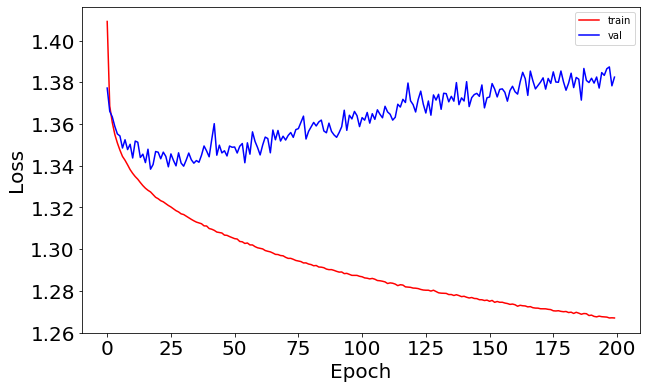

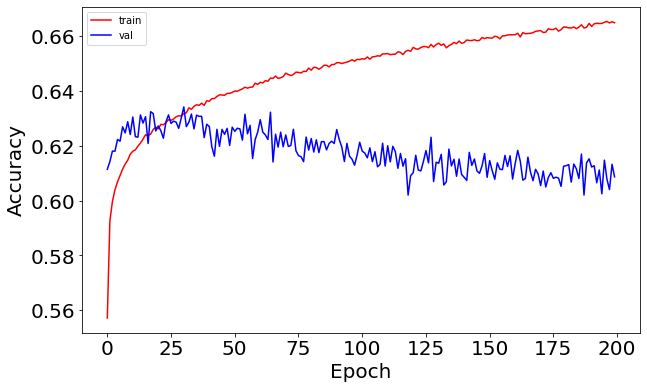

In [0]:
# plot the model loss.
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# plot the model accuracy.
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### Results.

In [0]:
# get a single observation and all features.
obs = genreframe.iloc[10000:10001,7:20].to_numpy()
obs.shape

(1, 13)

In [0]:
# use the model to predict the observation.
model.predict(obs)

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
# get the single observation genre.
genreframe.iloc[10000:10001,5]

10000    jazz
Name: genre, dtype: object

In [0]:
# save the model.
model.save('genre_NN')